In [1]:
seed = 314 

import numpy as np
np.random.seed(seed)
np.random.RandomState(seed)

import random
random.seed(seed)

import torch
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)


import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel

from sklearn.utils import class_weight
from transformers import get_linear_schedule_with_warmup
import pandas as pd
from torchmetrics import Accuracy
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

In [2]:
class NitroDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, tokenizer, seq_len=250):        
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])         
        tokenized = self.tokenizer(
            text,            
            max_length = self.seq_len,                                
            padding = "max_length",     # Pad to the specified max_length. 
            truncation = True,          # Truncate to the specified max_length. 
            add_special_tokens = True,  # Whether to insert [CLS], [SEP], <s>, etc.   
            return_attention_mask = True, 
            return_tensors = 'pt'            
        )         

        # TODO: change return type of target based on problem (clf or reg)
        return {
            "ids": torch.tensor(tokenized["input_ids"], dtype=torch.long).flatten(),
            "masks": torch.tensor(tokenized["attention_mask"], dtype=torch.long).flatten(),
            "target": torch.tensor(self.targets[idx], dtype=torch.float).flatten() 
            }

In [3]:
class Classifier(nn.Module):
    def __init__(self):        
        super().__init__() 
        self.seq = nn.Sequential(
            nn.Linear(768, 768*2),
            nn.BatchNorm1d(768*2),
            nn.Dropout(0.25),
            nn.GELU(),
            nn.Linear(768*2, 5),
            nn.Softmax(),
        )
    
    def forward(self, x):
        x = self.seq(x)
        return x

class mBERT_base(nn.Module):  
    def __init__(self):        
        super().__init__() 
        self.transformer = BertModel.from_pretrained("bert-base-multilingual-cased")       
        self.classifier = Classifier()           
   
    def forward(self, input_ids, attention_mask):        
        raw_output = self.transformer(input_ids, attention_mask, return_dict=True)        
        x = raw_output["pooler_output"]    
        out = self.classifier(x)         
        return out 
    

mbert_base_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


In [4]:
def plot_loss(name, epoch, train_loss, val_loss, w_accuracy, accuracy):
    plt.plot(range(1, 1+len(train_loss)), train_loss, color = 'blue', label = 'train_loss')
    plt.plot(range(1, 1+len(val_loss)), val_loss, color = 'green', label = 'val_loss')
    plt.title("Loss over "+str(epoch)+" epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.savefig(f"loss_e{epoch}_{name}.jpg")
    plt.show()

    print(w_accuracy, accuracy)
    plt.plot(range(1, 1+len(w_accuracy)), w_accuracy, color = 'blue', label = 'Acc')
    plt.plot(range(1, 1+len(accuracy)), accuracy, color = 'green', label = 'B_acc')
    plt.title("Acc over "+str(epoch)+" epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.legend(loc="upper left")
    plt.savefig(f"acc_e{epoch}_{name}.jpg")
    plt.show()

def weighted_accuracy(all_labels, sample_labels, predicted_labels):
    categories = np.unique(all_labels)
    cls_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = categories, y = all_labels)
    cls_weights_dict = {categories[i]: cls_weights[i] for i in range(len(categories))}
    val_sample_weights = class_weight.compute_sample_weight(class_weight = cls_weights_dict, y = sample_labels)
    return accuracy_score(sample_labels, predicted_labels, sample_weight=val_sample_weights)    


def train(config, model, train_loader, val_loader):

    model.to(config.device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

    weights = torch.tensor([0.10915805, 0.07564106, 0.03261642, 0.03791726, 0.74466722])
    weights = weights.to(config.device)
    criterion = nn.CrossEntropyLoss(weight = weights)

    train_losses, val_losses = [], []
    list_w_acc = []
    list_acc = []


    start_epoch = 0

    optimizer.zero_grad()



    train_steps_per_epoch = len(train_loader)
    num_train_steps = config.num_epochs * train_steps_per_epoch
    num_warmup_steps = int(0.1 * num_train_steps)


    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=num_train_steps)



    for epoch in range(start_epoch+1, config.num_epochs+1):

        model.train()
        epoch_loss = 0.0
        total_inputs = 0

        for k, data in enumerate(tqdm(train_loader)):

            inputs, masks, labels = data['ids'], data['masks'], data['target']
            inputs, masks, labels = inputs.to(config.device), masks.to(config.device), labels.to(config.device)
            labels = labels.flatten()
            labels = labels.long()
            
            # print(labels)
            # return None
            outputs = model(inputs, masks)
            #y_pred = torch.argmax(outputs, dim=0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item() * len(inputs)
            total_inputs += len(inputs)
            print(f"Loss: {loss.item()} Batch: {k} of {len(train_loader)}")
            optimizer.zero_grad()

        epoch_loss = epoch_loss / total_inputs
        train_losses.append(epoch_loss)

        print(f"Train epoch loss: {epoch_loss}")

        model.eval()
        epoch_loss = 0.0
        epoch_w_acc = 0.0
        epoch_acc = 0.0
        total_inputs = 0


        with torch.no_grad():

            for data in val_loader:

                inputs, masks, labels = data['ids'], data['masks'], data['target']
                inputs, masks, labels = inputs.to(config.device), masks.to(config.device), labels.to(config.device)
                labels = labels.flatten()
                labels = labels.long()
                outputs = model(inputs, masks)
                loss = criterion(outputs, labels)

                epoch_loss += loss.item() * len(inputs)
                total_inputs += len(inputs)

                w_acc_fn = Accuracy(task='multiclass', average='weighted', num_classes=5)
                w_acc_fn = w_acc_fn.to(config.device)
                w_accuracy = w_acc_fn(outputs, labels)
                w_accuracy = w_accuracy.cpu().numpy()

                predicted = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.cpu().numpy()  
                accuracy = accuracy_score(labels, predicted)
                epoch_w_acc += w_accuracy * len(inputs)
                epoch_acc += accuracy * len(inputs)



            epoch_w_acc = epoch_w_acc / total_inputs
            epoch_acc = epoch_acc / total_inputs

            list_w_acc.append(epoch_w_acc)
            list_acc.append(epoch_acc)

            epoch_loss = epoch_loss / total_inputs
            val_losses.append(epoch_loss)

        print(f"Val epoch loss: {epoch_loss} W_acc: {epoch_w_acc} Acc: {epoch_acc}")

        plot_loss(config.name_model, epoch, train_losses, val_losses, list_w_acc, list_acc)
        if epoch > 2:
            path = f"model_e{epoch}_{config.name_model}.pth"
            torch.save({
                'epoch': config.num_epochs,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss': train_losses,
                'val_loss': val_losses,
                'w_acc': list_w_acc,
                'acc': list_acc,
                'config': config.__dict__
            }, path)

In [5]:
def get_data(root):
    train_data = pd.read_csv('/kaggle/input/nitro-language-processing-2/train_data.csv')
    text_lists = [train_data[train_data["Final Labels"]==clasa] for clasa in np.unique(train_data["Final Labels"])]

    nonof = text_lists[2].iloc[:5000]
    train_data = pd.concat([text_lists[0],text_lists[1],nonof, text_lists[3],text_lists[4]])

    X, y = train_data['Text'].tolist(), np.array(train_data['Final Labels'].tolist())

    X_replaced = np.array([text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș") for text in X])

    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    config.all_labels = y

    X_train, X_val, y_train, y_val = train_test_split(X_replaced, y, test_size=0.20, random_state=42, shuffle=True)

    return X_train, X_val, y_train, y_val

def get_data_test(root):
    test_data = pd.read_csv(os.path.join(root, 'train_data.csv'))
    X = test_data['Text'].tolist()
    X_replaced = np.array([text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș") for text in X])
    return X_replaced

def get_datalaoder(config, tokenizer, root):

    X_train, X_val, y_train, y_val = get_data(root)

    train_data = NitroDataset(X_train, y_train, tokenizer)
    val_data = NitroDataset(X_val, y_val, tokenizer)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = config.batch_size, shuffle = True, pin_memory = True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size = config.batch_size, shuffle = False, pin_memory = True)

    return train_loader, val_loader

def get_test_loader(tokenizer, root):
    X = get_data_test(root)
    y = np.zeros(X.shape)
    test_data = NitroDataset(X, y, tokenizer)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1, shuffle = False)

    return test_loader

class ModelConfig():
    def __init__(self, 
                 name_model = "mBERTA-final-1e-5",
                 num_epochs = 10,
                 device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 batch_size =  40,
                 learning_rate = 1e-5,
                 dropout = [0.25],
                 mix_precision = False):
        
        self.name_model = name_model
        self.num_epochs = num_epochs
        self.device = device
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.mix_precision = mix_precision
        self.all_labels = None
        self.classes = ['descriptive', 'direct', 'non-offensive', 'offensive', 'reporting']

def submit_form(predictions):
    a = pd.DataFrame(enumerate(predictions), columns=['Id', 'Label'])
    a.to_csv("SUBMISIE.csv", index=False)

def inference(config, model, test_loader, load_model=True):

    if load_model == True:
        checkpoint = torch.load('model_e1_mBERT.pth')
        model.load_state_dict(checkpoint['model'])

    model.to(config.device)
    model.eval()
    predictions = []
    for k, data in enumerate(tqdm(test_loader)):

        inputs, masks, labels = data['ids'], data['masks'], data['target']
        inputs, masks, labels = inputs.to(config.device), masks.to(config.device), labels.to(config.device)
        labels = labels.flatten()
        labels = labels.long()
        
        with torch.no_grad():
            outputs = model(inputs, masks)
            y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.append(config.classes[y_pred[0]])
        print(f'Done with {k}/{len(test_loader)}')

    return predictions       

In [6]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
config = ModelConfig()
model = mBERT_base()

path = None
train_loader, val_loader = get_datalaoder(config, mbert_base_tokenizer, path)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.630208134651184 Batch: 0 of 264
Loss: 1.6032980680465698 Batch: 1 of 264
Loss: 1.6095577478408813 Batch: 2 of 264
Loss: 1.6105117797851562 Batch: 3 of 264
Loss: 1.6287667751312256 Batch: 4 of 264
Loss: 1.626563310623169 Batch: 5 of 264
Loss: 1.6086229085922241 Batch: 6 of 264
Loss: 1.654035210609436 Batch: 7 of 264
Loss: 1.604968547821045 Batch: 8 of 264
Loss: 1.605790376663208 Batch: 9 of 264
Loss: 1.5931862592697144 Batch: 10 of 264
Loss: 1.6024725437164307 Batch: 11 of 264
Loss: 1.6238014698028564 Batch: 12 of 264
Loss: 1.6373834609985352 Batch: 13 of 264
Loss: 1.6299958229064941 Batch: 14 of 264
Loss: 1.596592903137207 Batch: 15 of 264
Loss: 1.584922432899475 Batch: 16 of 264
Loss: 1.6058580875396729 Batch: 17 of 264
Loss: 1.6673390865325928 Batch: 18 of 264
Loss: 1.630317211151123 Batch: 19 of 264
Loss: 1.612324833869934 Batch: 20 of 264
Loss: 1.634355068206787 Batch: 21 of 264
Loss: 1.625036358833313 Batch: 22 of 264
Loss: 1.6087331771850586 Batch: 23 of 264
Loss: 1.57044

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.442301460442076 W_acc: 0.38154898295369943 Acc: 0.3815489749430524


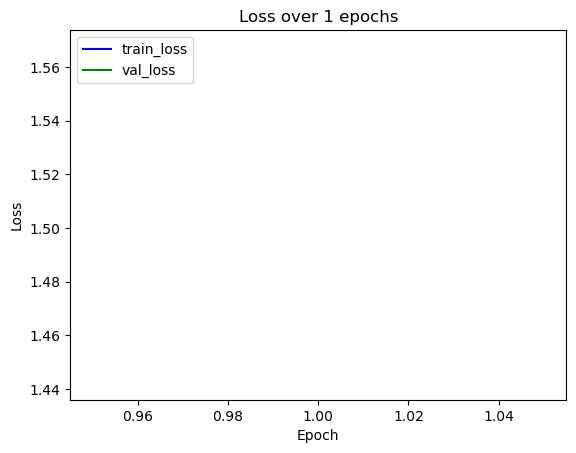

[0.38154898295369943] [0.3815489749430524]


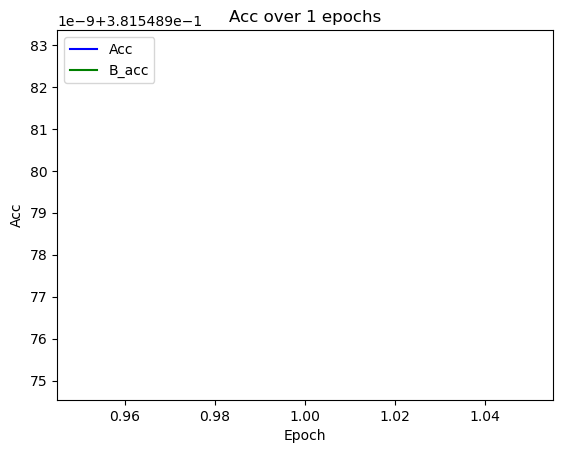

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.4517215490341187 Batch: 0 of 264
Loss: 1.4062316417694092 Batch: 1 of 264
Loss: 1.485454797744751 Batch: 2 of 264
Loss: 1.4551397562026978 Batch: 3 of 264
Loss: 1.4363107681274414 Batch: 4 of 264
Loss: 1.3975837230682373 Batch: 5 of 264
Loss: 1.4402790069580078 Batch: 6 of 264
Loss: 1.4369475841522217 Batch: 7 of 264
Loss: 1.3874367475509644 Batch: 8 of 264
Loss: 1.4164695739746094 Batch: 9 of 264
Loss: 1.4709317684173584 Batch: 10 of 264
Loss: 1.4672516584396362 Batch: 11 of 264
Loss: 1.3615531921386719 Batch: 12 of 264
Loss: 1.5344576835632324 Batch: 13 of 264
Loss: 1.275459885597229 Batch: 14 of 264
Loss: 1.348676085472107 Batch: 15 of 264
Loss: 1.475494623184204 Batch: 16 of 264
Loss: 1.3979473114013672 Batch: 17 of 264
Loss: 1.6204124689102173 Batch: 18 of 264
Loss: 1.3331568241119385 Batch: 19 of 264
Loss: 1.3666051626205444 Batch: 20 of 264
Loss: 1.4093396663665771 Batch: 21 of 264
Loss: 1.3392353057861328 Batch: 22 of 264
Loss: 1.4534120559692383 Batch: 23 of 264
Loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.2969097475618148 W_acc: 0.6207289362641656 Acc: 0.6207289293849658


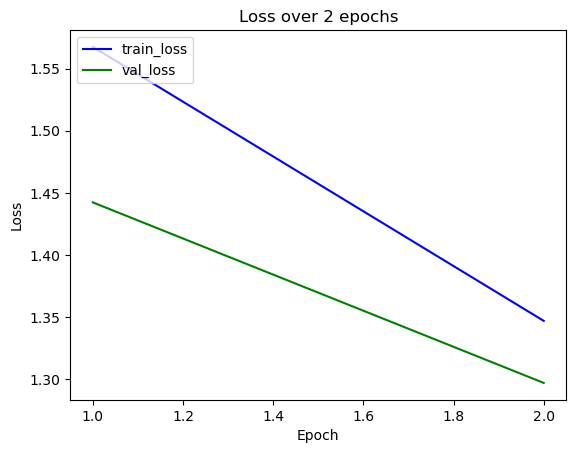

[0.38154898295369943, 0.6207289362641656] [0.3815489749430524, 0.6207289293849658]


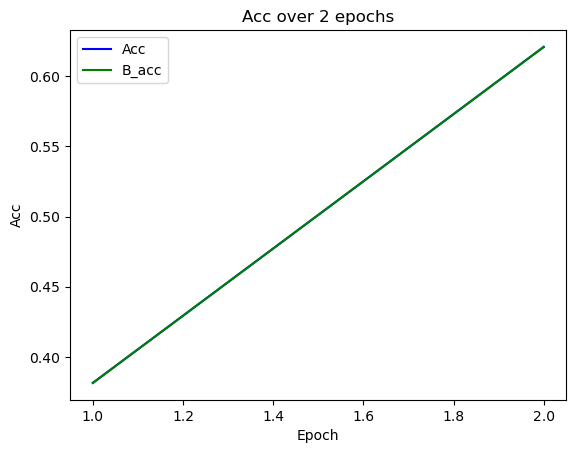

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.3600965738296509 Batch: 0 of 264
Loss: 1.3292016983032227 Batch: 1 of 264
Loss: 1.1648285388946533 Batch: 2 of 264
Loss: 1.3106591701507568 Batch: 3 of 264
Loss: 1.1119530200958252 Batch: 4 of 264
Loss: 1.2330244779586792 Batch: 5 of 264
Loss: 1.328908085823059 Batch: 6 of 264
Loss: 1.2790203094482422 Batch: 7 of 264
Loss: 1.2094566822052002 Batch: 8 of 264
Loss: 1.1109294891357422 Batch: 9 of 264
Loss: 1.1517857313156128 Batch: 10 of 264
Loss: 1.187974452972412 Batch: 11 of 264
Loss: 1.096433162689209 Batch: 12 of 264
Loss: 1.4647904634475708 Batch: 13 of 264
Loss: 1.1234025955200195 Batch: 14 of 264
Loss: 1.2418619394302368 Batch: 15 of 264
Loss: 1.2169568538665771 Batch: 16 of 264
Loss: 1.3404531478881836 Batch: 17 of 264
Loss: 1.3453046083450317 Batch: 18 of 264
Loss: 1.1443912982940674 Batch: 19 of 264
Loss: 1.2523294687271118 Batch: 20 of 264
Loss: 1.2580347061157227 Batch: 21 of 264
Loss: 1.267380714416504 Batch: 22 of 264
Loss: 1.2617658376693726 Batch: 23 of 264
Loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.2671560905336339 W_acc: 0.647684135306669 Acc: 0.6476841305998481


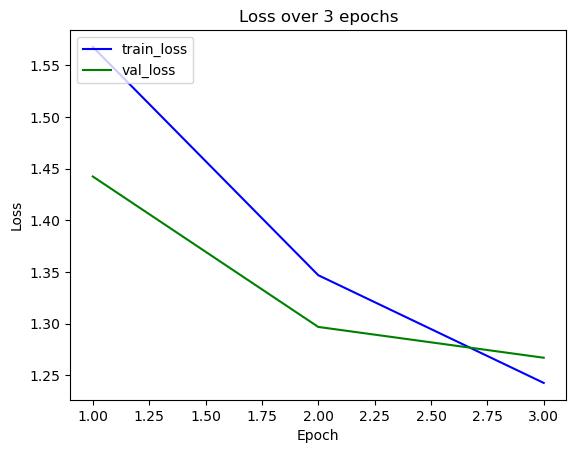

[0.38154898295369943, 0.6207289362641656, 0.647684135306669] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481]


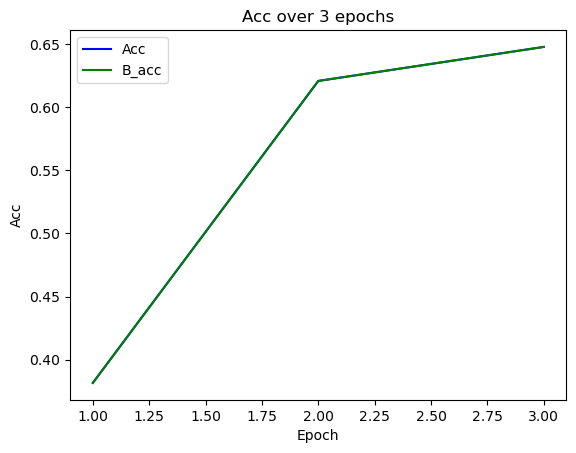

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.1057169437408447 Batch: 0 of 264
Loss: 1.096584677696228 Batch: 1 of 264
Loss: 1.2646870613098145 Batch: 2 of 264
Loss: 1.1617774963378906 Batch: 3 of 264
Loss: 1.2983225584030151 Batch: 4 of 264
Loss: 1.3641279935836792 Batch: 5 of 264
Loss: 1.1053682565689087 Batch: 6 of 264
Loss: 1.3388999700546265 Batch: 7 of 264
Loss: 1.2147701978683472 Batch: 8 of 264
Loss: 1.3096752166748047 Batch: 9 of 264
Loss: 1.1105667352676392 Batch: 10 of 264
Loss: 1.327287197113037 Batch: 11 of 264
Loss: 1.2670812606811523 Batch: 12 of 264
Loss: 1.0687507390975952 Batch: 13 of 264
Loss: 1.1267210245132446 Batch: 14 of 264
Loss: 1.312738299369812 Batch: 15 of 264
Loss: 1.1517229080200195 Batch: 16 of 264
Loss: 1.1204720735549927 Batch: 17 of 264
Loss: 1.2686519622802734 Batch: 18 of 264
Loss: 1.2076833248138428 Batch: 19 of 264
Loss: 1.1811376810073853 Batch: 20 of 264
Loss: 1.2624934911727905 Batch: 21 of 264
Loss: 1.314029335975647 Batch: 22 of 264
Loss: 1.4213966131210327 Batch: 23 of 264
Loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.2718942782692413 W_acc: 0.6332574069907291 Acc: 0.6332574031890661


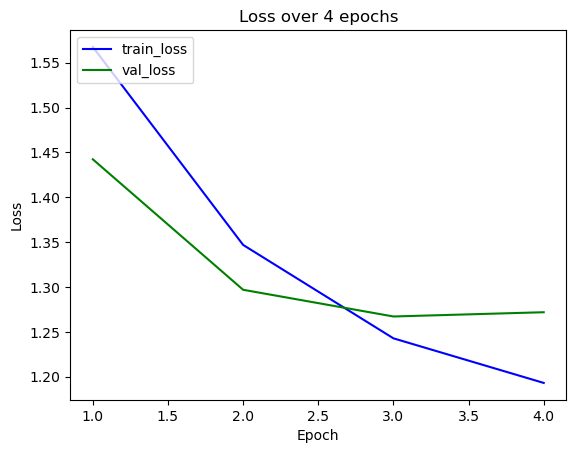

[0.38154898295369943, 0.6207289362641656, 0.647684135306669, 0.6332574069907291] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481, 0.6332574031890661]


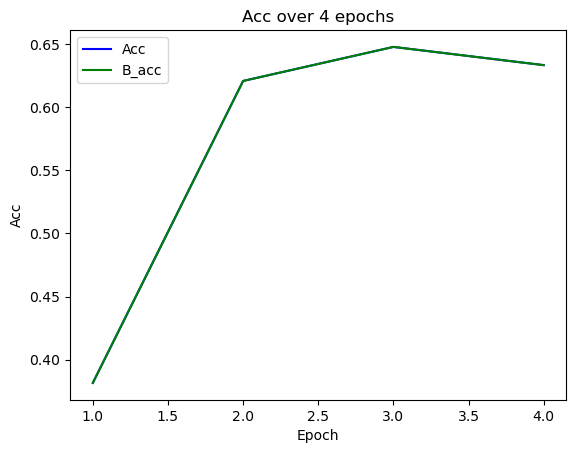

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.224889874458313 Batch: 0 of 264
Loss: 1.1963872909545898 Batch: 1 of 264
Loss: 1.2382036447525024 Batch: 2 of 264
Loss: 1.1518213748931885 Batch: 3 of 264
Loss: 1.0765200853347778 Batch: 4 of 264
Loss: 1.0895553827285767 Batch: 5 of 264
Loss: 1.1368122100830078 Batch: 6 of 264
Loss: 1.140634298324585 Batch: 7 of 264
Loss: 1.1795982122421265 Batch: 8 of 264
Loss: 1.2281770706176758 Batch: 9 of 264
Loss: 1.2450506687164307 Batch: 10 of 264
Loss: 1.2283027172088623 Batch: 11 of 264
Loss: 1.1601550579071045 Batch: 12 of 264
Loss: 1.075250506401062 Batch: 13 of 264
Loss: 1.0797021389007568 Batch: 14 of 264
Loss: 1.0919270515441895 Batch: 15 of 264
Loss: 1.1472017765045166 Batch: 16 of 264
Loss: 1.2120180130004883 Batch: 17 of 264
Loss: 1.307790756225586 Batch: 18 of 264
Loss: 1.019767165184021 Batch: 19 of 264
Loss: 1.0297170877456665 Batch: 20 of 264
Loss: 1.0957072973251343 Batch: 21 of 264
Loss: 1.0828765630722046 Batch: 22 of 264
Loss: 1.2951432466506958 Batch: 23 of 264
Loss: 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.2298671931322542 W_acc: 0.7065299905966699 Acc: 0.7065299924069856


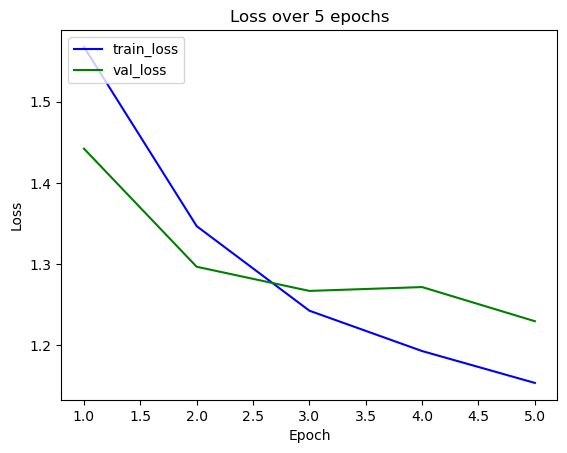

[0.38154898295369943, 0.6207289362641656, 0.647684135306669, 0.6332574069907291, 0.7065299905966699] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481, 0.6332574031890661, 0.7065299924069856]


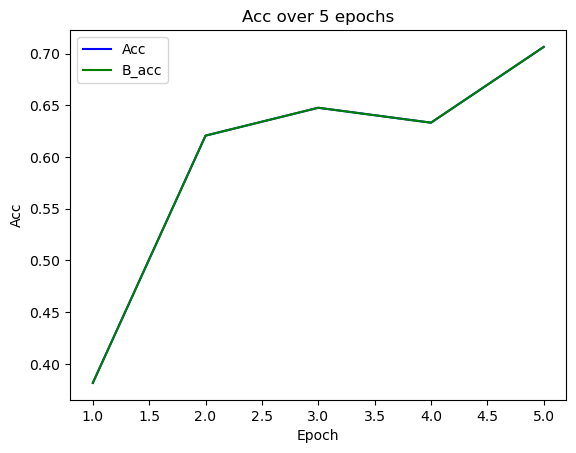

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 0.9727335572242737 Batch: 0 of 264
Loss: 1.0573952198028564 Batch: 1 of 264
Loss: 1.0017949342727661 Batch: 2 of 264
Loss: 0.9821042418479919 Batch: 3 of 264
Loss: 1.121900200843811 Batch: 4 of 264
Loss: 1.4214447736740112 Batch: 5 of 264
Loss: 1.0906124114990234 Batch: 6 of 264
Loss: 1.1532084941864014 Batch: 7 of 264
Loss: 1.1558618545532227 Batch: 8 of 264
Loss: 1.0702118873596191 Batch: 9 of 264
Loss: 1.0646058320999146 Batch: 10 of 264
Loss: 1.0578224658966064 Batch: 11 of 264
Loss: 1.2281222343444824 Batch: 12 of 264
Loss: 1.0753824710845947 Batch: 13 of 264
Loss: 1.0896257162094116 Batch: 14 of 264
Loss: 1.0744705200195312 Batch: 15 of 264
Loss: 1.0968716144561768 Batch: 16 of 264
Loss: 1.1384040117263794 Batch: 17 of 264
Loss: 1.1545597314834595 Batch: 18 of 264
Loss: 1.1215901374816895 Batch: 19 of 264
Loss: 1.1932018995285034 Batch: 20 of 264
Loss: 1.0152595043182373 Batch: 21 of 264
Loss: 1.1029621362686157 Batch: 22 of 264
Loss: 1.1829261779785156 Batch: 23 of 264
Los

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.2253640697322836 W_acc: 0.6928625719603392 Acc: 0.6928625664388762


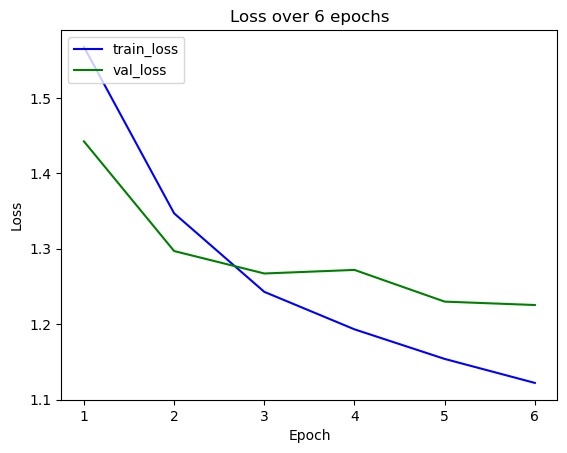

[0.38154898295369943, 0.6207289362641656, 0.647684135306669, 0.6332574069907291, 0.7065299905966699, 0.6928625719603392] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481, 0.6332574031890661, 0.7065299924069856, 0.6928625664388762]


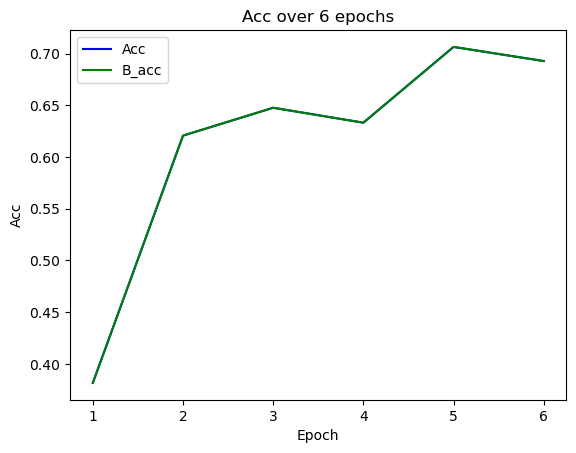

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.1275043487548828 Batch: 0 of 264
Loss: 1.0138682126998901 Batch: 1 of 264
Loss: 1.0418267250061035 Batch: 2 of 264
Loss: 1.0015310049057007 Batch: 3 of 264
Loss: 1.1281682252883911 Batch: 4 of 264
Loss: 1.0387892723083496 Batch: 5 of 264
Loss: 1.0231101512908936 Batch: 6 of 264
Loss: 1.1136716604232788 Batch: 7 of 264
Loss: 0.983244001865387 Batch: 8 of 264
Loss: 1.191268801689148 Batch: 9 of 264
Loss: 1.1313751935958862 Batch: 10 of 264
Loss: 1.048561692237854 Batch: 11 of 264
Loss: 1.0046755075454712 Batch: 12 of 264
Loss: 1.2267653942108154 Batch: 13 of 264
Loss: 1.0274604558944702 Batch: 14 of 264
Loss: 1.2820205688476562 Batch: 15 of 264
Loss: 1.069278359413147 Batch: 16 of 264
Loss: 1.1382664442062378 Batch: 17 of 264
Loss: 1.3171215057373047 Batch: 18 of 264
Loss: 1.1522663831710815 Batch: 19 of 264
Loss: 1.1067787408828735 Batch: 20 of 264
Loss: 0.9739115834236145 Batch: 21 of 264
Loss: 1.121394157409668 Batch: 22 of 264
Loss: 1.0577048063278198 Batch: 23 of 264
Loss: 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.2362237026407217 W_acc: 0.7050113877565822 Acc: 0.7050113895216401


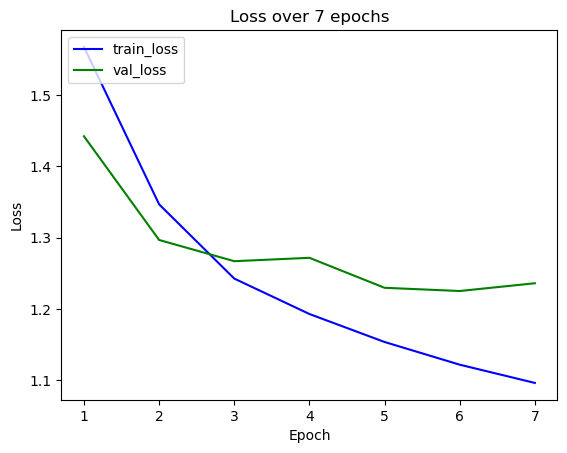

[0.38154898295369943, 0.6207289362641656, 0.647684135306669, 0.6332574069907291, 0.7065299905966699, 0.6928625719603392, 0.7050113877565822] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481, 0.6332574031890661, 0.7065299924069856, 0.6928625664388762, 0.7050113895216401]


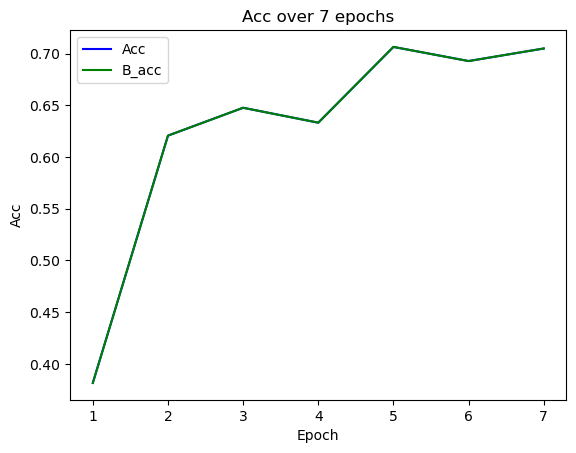

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 0.9974570870399475 Batch: 0 of 264
Loss: 1.0698676109313965 Batch: 1 of 264
Loss: 1.0962659120559692 Batch: 2 of 264
Loss: 1.0850082635879517 Batch: 3 of 264
Loss: 0.9972818493843079 Batch: 4 of 264
Loss: 0.9579969644546509 Batch: 5 of 264
Loss: 1.0496939420700073 Batch: 6 of 264
Loss: 1.011385440826416 Batch: 7 of 264
Loss: 1.0603102445602417 Batch: 8 of 264
Loss: 1.002015471458435 Batch: 9 of 264
Loss: 1.0110628604888916 Batch: 10 of 264
Loss: 1.068619966506958 Batch: 11 of 264
Loss: 1.0799695253372192 Batch: 12 of 264
Loss: 1.1600761413574219 Batch: 13 of 264
Loss: 1.1127996444702148 Batch: 14 of 264
Loss: 1.1005347967147827 Batch: 15 of 264
Loss: 1.09530508518219 Batch: 16 of 264
Loss: 1.097297191619873 Batch: 17 of 264
Loss: 1.1920520067214966 Batch: 18 of 264
Loss: 1.1185635328292847 Batch: 19 of 264
Loss: 1.1282557249069214 Batch: 20 of 264
Loss: 1.0941874980926514 Batch: 21 of 264
Loss: 1.0918711423873901 Batch: 22 of 264
Loss: 1.0695751905441284 Batch: 23 of 264
Loss: 1.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.226761262436753 W_acc: 0.7103265018379861 Acc: 0.7103264996203493


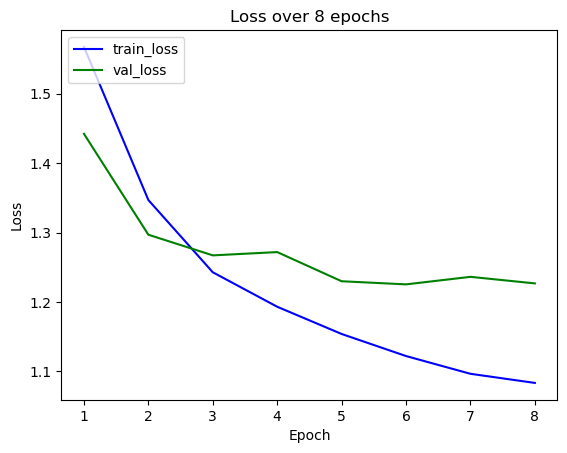

[0.38154898295369943, 0.6207289362641656, 0.647684135306669, 0.6332574069907291, 0.7065299905966699, 0.6928625719603392, 0.7050113877565822, 0.7103265018379861] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481, 0.6332574031890661, 0.7065299924069856, 0.6928625664388762, 0.7050113895216401, 0.7103264996203493]


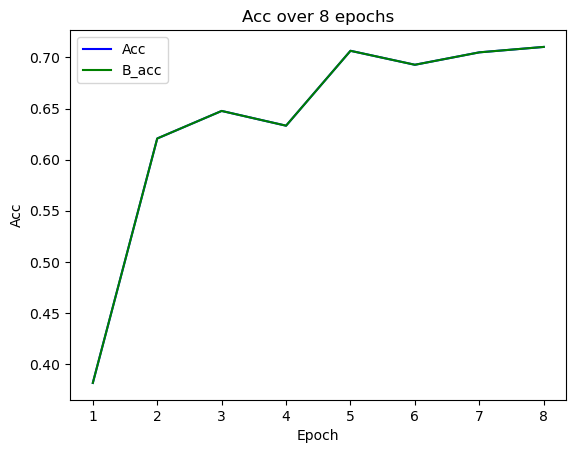

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.3539780378341675 Batch: 0 of 264
Loss: 1.0929104089736938 Batch: 1 of 264
Loss: 1.0221002101898193 Batch: 2 of 264
Loss: 1.0303469896316528 Batch: 3 of 264
Loss: 0.9666271209716797 Batch: 4 of 264
Loss: 1.060895562171936 Batch: 5 of 264
Loss: 1.1056592464447021 Batch: 6 of 264
Loss: 1.0141180753707886 Batch: 7 of 264
Loss: 1.0063196420669556 Batch: 8 of 264
Loss: 1.0190881490707397 Batch: 9 of 264
Loss: 1.052717924118042 Batch: 10 of 264
Loss: 1.096666693687439 Batch: 11 of 264
Loss: 1.0109666585922241 Batch: 12 of 264
Loss: 1.015086054801941 Batch: 13 of 264
Loss: 1.0594844818115234 Batch: 14 of 264
Loss: 1.038068413734436 Batch: 15 of 264
Loss: 1.0405727624893188 Batch: 16 of 264
Loss: 1.0723741054534912 Batch: 17 of 264
Loss: 1.1825250387191772 Batch: 18 of 264
Loss: 1.0437647104263306 Batch: 19 of 264
Loss: 0.9857451915740967 Batch: 20 of 264
Loss: 0.9692455530166626 Batch: 21 of 264
Loss: 1.1059004068374634 Batch: 22 of 264
Loss: 0.9583579897880554 Batch: 23 of 264
Loss: 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.2251834544433096 W_acc: 0.7061503478859805 Acc: 0.7061503416856492


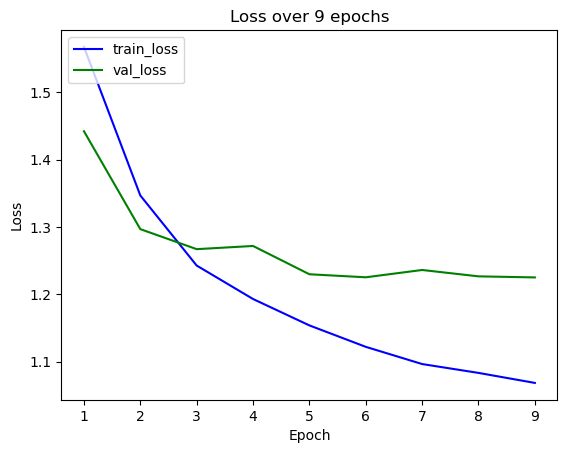

[0.38154898295369943, 0.6207289362641656, 0.647684135306669, 0.6332574069907291, 0.7065299905966699, 0.6928625719603392, 0.7050113877565822, 0.7103265018379861, 0.7061503478859805] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481, 0.6332574031890661, 0.7065299924069856, 0.6928625664388762, 0.7050113895216401, 0.7103264996203493, 0.7061503416856492]


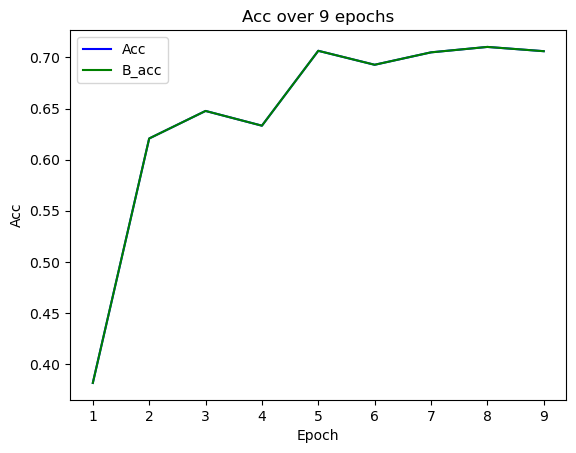

  0%|          | 0/264 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 1.0470552444458008 Batch: 0 of 264
Loss: 1.2489678859710693 Batch: 1 of 264
Loss: 0.9615929126739502 Batch: 2 of 264
Loss: 1.2456711530685425 Batch: 3 of 264
Loss: 1.0100109577178955 Batch: 4 of 264
Loss: 1.1449792385101318 Batch: 5 of 264
Loss: 0.990997314453125 Batch: 6 of 264
Loss: 1.1639732122421265 Batch: 7 of 264
Loss: 1.0198277235031128 Batch: 8 of 264
Loss: 1.0827422142028809 Batch: 9 of 264
Loss: 1.0446006059646606 Batch: 10 of 264
Loss: 1.0513153076171875 Batch: 11 of 264
Loss: 1.0593901872634888 Batch: 12 of 264
Loss: 1.1471620798110962 Batch: 13 of 264
Loss: 0.9588599801063538 Batch: 14 of 264
Loss: 1.14378023147583 Batch: 15 of 264
Loss: 1.1552205085754395 Batch: 16 of 264
Loss: 0.9478838443756104 Batch: 17 of 264
Loss: 1.0437160730361938 Batch: 18 of 264
Loss: 1.1351977586746216 Batch: 19 of 264
Loss: 1.0094985961914062 Batch: 20 of 264
Loss: 1.0058510303497314 Batch: 21 of 264
Loss: 1.0719679594039917 Batch: 22 of 264
Loss: 1.144895076751709 Batch: 23 of 264
Loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

Val epoch loss: 1.224063246831264 W_acc: 0.7141230136223969 Acc: 0.714123006833713


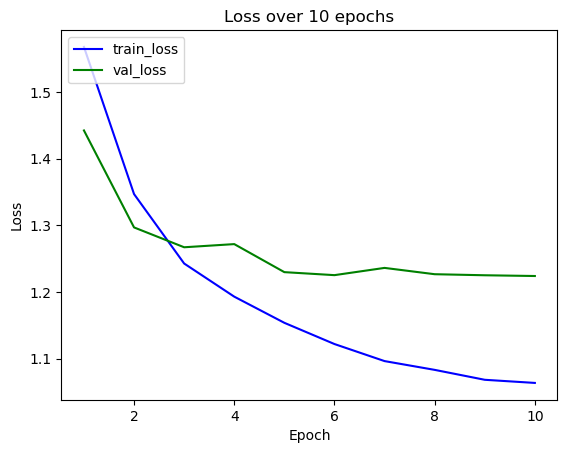

[0.38154898295369943, 0.6207289362641656, 0.647684135306669, 0.6332574069907291, 0.7065299905966699, 0.6928625719603392, 0.7050113877565822, 0.7103265018379861, 0.7061503478859805, 0.7141230136223969] [0.3815489749430524, 0.6207289293849658, 0.6476841305998481, 0.6332574031890661, 0.7065299924069856, 0.6928625664388762, 0.7050113895216401, 0.7103264996203493, 0.7061503416856492, 0.714123006833713]


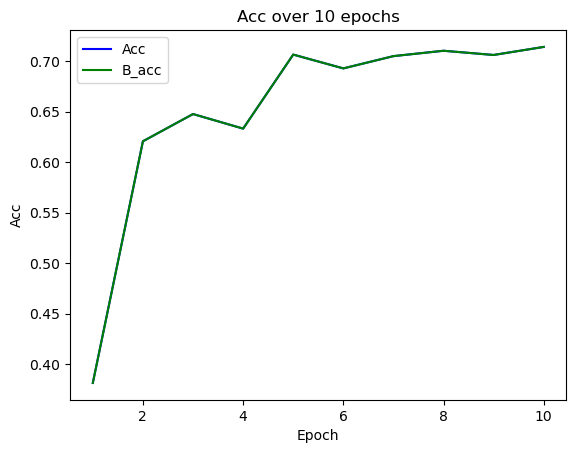

In [7]:
train(config, model, train_loader, val_loader)
